In [1]:
from pathlib import Path
from ardi.dataset import SocialVAEDataset
import numpy as np
from ardi.prediction import LinearPredictor, PowerlawPredictor, SocialVAEPredictor, VelocityCalc, PrefVelocityCalc, Predictor

In [2]:
test_ds = SocialVAEDataset("../../SocialVAE/data/zucker_day_controller_scene/19/cadrl/overtake/23_0.txt")

In [3]:
lp = LinearPredictor(8, VelocityCalc.LAST_DISPLACEMENT)
pp = PowerlawPredictor(8, VelocityCalc.LAST_DISPLACEMENT, PrefVelocityCalc.FIX_MAG_ORACLE_DIR)
sp = SocialVAEPredictor("../../SocialVAE/models/zara01/ckpt-best", 4, 5, 8, VelocityCalc.LAST_DISPLACEMENT, "cuda:0")
predictors = {
    "Linear": lp,
    "Powerlaw": pp,
    "SocialVAE": sp
}

lp_ades, lp_fdes = lp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)
pp_ades, pp_fdes = pp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)
sp_ades, sp_fdes = sp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)

print(np.mean(lp_ades), np.mean(lp_fdes))
print(np.mean(pp_ades), np.mean(pp_fdes))
print(np.mean(sp_ades), np.mean(sp_fdes))

0.3145340106836143 0.7124782817872577
0.2297543604784849 0.37006448538139813
0.2613672860273698 0.46018564937364387


In [7]:
%matplotlib inline

from tqdm import tqdm
from typing import Dict, Tuple, List

results = {}

def get_results(predictors: Dict[str, Predictor], root: str, glob: str) -> Dict[str, Dict[str, Tuple[List[float], List[float]]]]:
    for i, fn in tqdm(list(enumerate(Path(root).glob(glob)))):
        day, controller, scene = str(fn).split("/")[5:8]
        idx, offset = fn.stem.split("_")
        img_root = Path(f"./{controller}/{scene}")
        img_root.mkdir(parents=True, exist_ok=True)
        
        ds = SocialVAEDataset(str(fn))
        results[str(fn)] = {}

        for name in predictors:
            ades, fdes = results[str(fn)][name] = predictors[name].predict_dataset(
                ds,
                5,
                [i for i in ds.agents if i != -1],
                True,
                str(img_root) + f"/{day}_{idx}_{offset}"
            )
        
    return results

results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/*/*/*txt")

  6%|▌         | 192/3264 [07:53<2:06:09,  2.46s/it]


RuntimeError: The size of tensor a (0) must match the size of tensor b (5) at non-singleton dimension 0

In [7]:
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()

def plot_results(results: Dict[str, Dict[str, Tuple[List[float], List[float]]]], title: str):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    plot_fn = sns.kdeplot

    plot_fn([x for x in [results[key]["Linear"][0] for key in results] for x in x], label="Linear", ax=axs[0])
    plot_fn([x for x in [results[key]["SocialVAE"][0] for key in results] for x in x], label="SocialVAE", ax=axs[0])
    plot_fn([x for x in [results[key]["Powerlaw"][0] for key in results] for x in x], label="Powerlaw", ax=axs[0])

    plot_fn([x for x in [results[key]["Linear"][1] for key in results] for x in x], label="Linear", ax=axs[1])
    plot_fn([x for x in [results[key]["SocialVAE"][1] for key in results] for x in x], label="SocialVAE", ax=axs[1])
    plot_fn([x for x in [results[key]["Powerlaw"][1] for key in results] for x in x], label="Powerlaw", ax=axs[1])

    axs[0].set_ylabel("ADE Density")
    axs[1].set_ylabel("FDE Density")

    plt.suptitle(title)
    plt.legend()

100%|██████████| 96/96 [00:17<00:00,  5.57it/s]


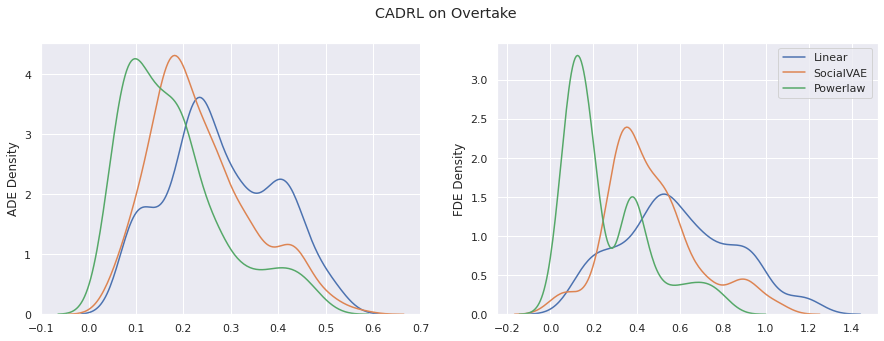

In [13]:
results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/cadrl/overtake/*txt")
plot_results(results, "CADRL on Overtake")

100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


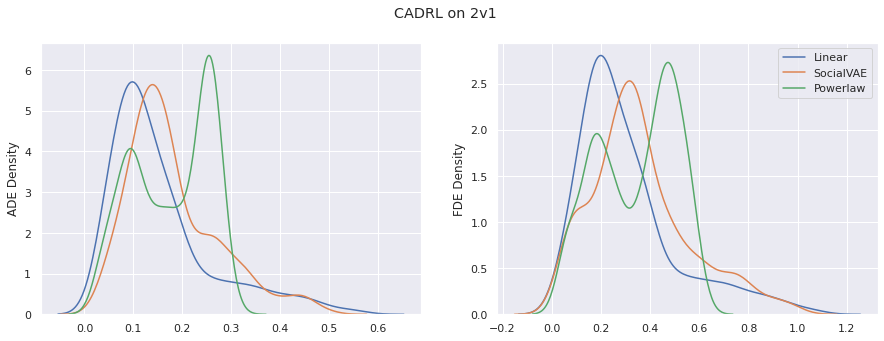

In [16]:
results = get_results(predictors, "../../SocialVAE/data/zucker_day_controller_scene/", "./*/cadrl/2v1/*txt")
plot_results(results, "CADRL on 2v1")